# CURRICULUM VITAE
## Luca Fontanili

<center>
    <i>Currently Head of Innovation Area in Cedacri; former Data Scientist and Back-End developer.<br>
Big Data lover, AI/ML enthusiast, eager learner, teammate.</i>
<a href="https://www.youracclaim.com/badges/61dfd9e1-489e-405a-ad04-ef48305cd618"><img src="images/aws-csaa.png" width=100 align="center"></a>
</center>

## PERSONAL INFORMATION


In [34]:
from IPython.core.display import display, HTML

#with open('setup.html') as f:
#    display(HTML(f.read()))

import pandas as pd
pd.set_option('max_colwidth', 1000)
import sqlite3

conn = sqlite3.connect('legacy/cv.db')
lf = pd.read_sql_query('SELECT * FROM users WHERE id="luca fontanili"', conn, index_col='id')
display(HTML('<center><table><tr><td><img src="images/profile.jpeg" width=230 style="border-radius: 50%;"/></td><td>{}</td></table></center>'
             .format(lf.T.to_html(escape=False))))

### WordCloud of experiences

<details><summary>➤ show me the code</summary>

<p>

```python
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_gradient_magnitude

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = os.getcwd()

# load wikipedia text on rainbow
text = long_text

# load image. This has been modified in gimp to be brighter and have more saturation.
parrot_color = np.array(Image.open(os.path.join(d, "background.jpeg")))
# subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
parrot_color = parrot_color[::3, ::3]

# create mask  white is "masked out"
parrot_mask = parrot_color.copy()
parrot_mask[parrot_mask.sum(axis=2) == 0] = 255

# some finesse: we enforce boundaries between colors so they get less washed out.
# For that we do some edge detection in the image
edges = np.mean([gaussian_gradient_magnitude(parrot_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
parrot_mask[edges > .08] = 255

stopwords = set(STOPWORDS)
stopwords.add("different")

# create wordcloud. A bit sluggish, you can subsample more strongly for quicker rendering
# relative_scaling=0 means the frequencies in the data are reflected less
# acurately but it makes a better picture
wc = WordCloud(max_words=2000, mask=parrot_mask, max_font_size=40, random_state=42, relative_scaling=0, stopwords=stopwords)

# generate word cloud
wc.generate(text)

# create coloring from image
image_colors = ImageColorGenerator(parrot_color)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
wc.to_file("word_cloud.png")
plt.show()

```

 

</p>

</details>

<img src="word_cloud.png" width=500 align="center">

In [4]:
from IPython.display import IFrame
IFrame(open('iframe.txt').read(),width=1200, height=350)

<center>
<div id="banner">
    <div style="display: inline-block;">
        <a href="https://github.com/lucafon"><img src ="github.png" width=50></a>
    </div>
    <div style="display: inline-block;">
        <a href="https://www.linkedin.com/in/luca-fontanili"><img src ="linkedin.png" width=50></a>
    </div>
    <div style="display: inline-block;">
        <a href="https://pypi.org/user/lucafon"><img src ="pypi.png" width=100></a>
    </div>
</div>
</center>

### DOWNLOAD A COPY

In [3]:
with open('download.html') as f:
    display(HTML(f.read()))

PDF,HTML


_______________
## WORK EXPERIENCE

### February 2020 - Present, Innovation Area Manager
<img src="cedacri.png" width=50 align="right">

#### Cedacri, Parma
**Business or sector** Research & Development, Data & Analytics, Machine Learning, Cloud

### February 2019 - February 2020 (1 year), Senior Engineer ML - Data Scientist
<img src="myinvenio.png" width=50 align="right">

#### MyInvenio, Reggio Emilia
**Business or sector** Data Science, Machine Learning, Process Discovery & Mining

### March 2015 - February 2019 (3 years 11 months), Computer Engineer – Software Development Leader
<img src="sia.png" width=50 align="right">

#### Ubiq S.R.L. - SIA Group, Parma/Milan
**Business or sector** Computer Engineering, Big Data, Machine Learning

### August 2014 - February 2015 (7 months), Software Engineering Intern
<img src="datalogic.png" width=90 align="right">

#### Datalogic ADC Inc, 55 W Del Mar Blvd, Pasadena (CA)

**Business or sector** Computer Vision

In [50]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize
import string

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

working_experiences = pd.read_sql_query('SELECT * FROM work_experiences where employer in ("Ubiq", "MyInvenio", "Cedacri", "Datalogic")', conn)
descriptions = working_experiences.drop(['employer', 'keyword'], axis=1)
keywords = working_experiences.drop(['employer', 'description'], axis=1)
employers = working_experiences.drop(['description', 'keyword'], axis=1)

def split_and_clean(input_string):
    return word_tokenize(str(input_string).lower().translate(str.maketrans('', '', string.punctuation)))

words = []
long_text = ''
for idx in range(0, len(descriptions)):
    long_text += descriptions.iloc[idx]['description']
    word_list = [word for word in split_and_clean(descriptions.iloc[idx]['description']) if not word in stopwords.words()]
    word_list += ([word for word in split_and_clean(keywords.iloc[idx]['keyword']) if not word in stopwords.words()])
    words.append(word_list)

hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**10)
X = hvec.fit_transform(words)
tsne = TSNE(perplexity=5, method='exact')
X_embedded = tsne.fit_transform(X.toarray())

working_experiences['x'] = X_embedded[:,0]
working_experiences['y'] = X_embedded[:,1]

k = 7
kmeans = KMeans(n_clusters=k, n_jobs=8)
y_pred = kmeans.fit_predict(X_embedded)

In [51]:
from bokeh.models import ColumnDataSource, HoverTool, LabelSet, RadioButtonGroup, CheckboxGroup, Slider
from bokeh.transform import linear_cmap
from bokeh.palettes import Blues9
from bokeh.io import output_file, save
from bokeh.plotting import figure
from bokeh.layouts import column 
from bokeh.models.callbacks import CustomJS

output_file("html/skills_scatter_plot.html")

y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(x= X_embedded[:,0], y= X_embedded[:,1], x_backup = X_embedded[:,0],
                                    y_backup = X_embedded[:,1], desc= y_labels, descriptions= working_experiences['description'],
                                    employers = working_experiences['employer'], keywords = working_experiences['keyword'], 
                                    level = working_experiences['managerial_level']
                                    ))

# map colors
mapper = linear_cmap(field_name='desc', palette=Blues9,low=min(y_labels), high=max(y_labels))

# hover over information
hover = HoverTool(tooltips=[
    ("Employer", "<b>@employers{safe}</b>"),
    ("Keyword", "<b>@keywords{safe}</b>"),
    ("Description", "@descriptions{safe}")
    ],
    point_policy="follow_mouse")

p = figure(plot_width=650, plot_height=650, tools=[hover], title="Cluster of all Working Experiences", toolbar_location=None)
#p.background_fill_color = "#323A48"
#p.border_fill_color = "#323A48"
p.xaxis.major_label_text_color = None
p.yaxis.major_label_text_color = None
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#p.title.text_color = "white"

# plot
p.scatter('x', 'y', size=10, source=source, fill_color=mapper, line_alpha=0.3, line_color="black")

labels = LabelSet(x="x", y="y", text="keywords", y_offset=-20, text_font_size="9pt", #text_color="#FFFFFF",
                      source=source, text_align='center')
p.add_layout(labels)

work_labels = ['All'] + list(working_experiences.employer.unique())

option = RadioButtonGroup(labels=work_labels, active=0)
skill_type_slider = Slider(start=1, end=3, value=1, step=1, title="Managerial Level")

callback = CustomJS(args=dict(p=p, source=source, level=skill_type_slider, option=option), code="""
    var radio_value = option.active;
    const current_level = level.value;
    
    var x = source.data.x;
    var y = source.data.y;
    var x_orig = source.data.x_backup;
    var y_orig = source.data.y_backup;
    var employers = source.data.employers;
    var levels = source.data.level;

    for (var i = 0; i < x.length; i++) {
        if((levels[i] >= current_level) && (employers[i] == option.labels[radio_value] || option.labels[radio_value] == 'All')) {
            x[i] = x_orig[i]
            y[i] = y_orig[i]
        } else {
            x[i] = undefined
            y[i] = undefined
        }
    }
    
    p.title.text = 'Cluster of Working Experiences in ' + option.labels[radio_value]
    
    source.change.emit();

""")

option.js_on_click(callback)
skill_type_slider.js_on_change('value', callback)

checkbox_group = CheckboxGroup(labels=['Labels'], active=[0])
checkbox_group.js_on_click(CustomJS(args=dict(labels=labels),code="""
    if(this.active == '0') {
        labels.visible = true
        console.log('true')
    } else {
        labels.visible = false
    }
    labels.change.emit();
"""))

show(column(column(column(column(option),checkbox_group), skill_type_slider),p))

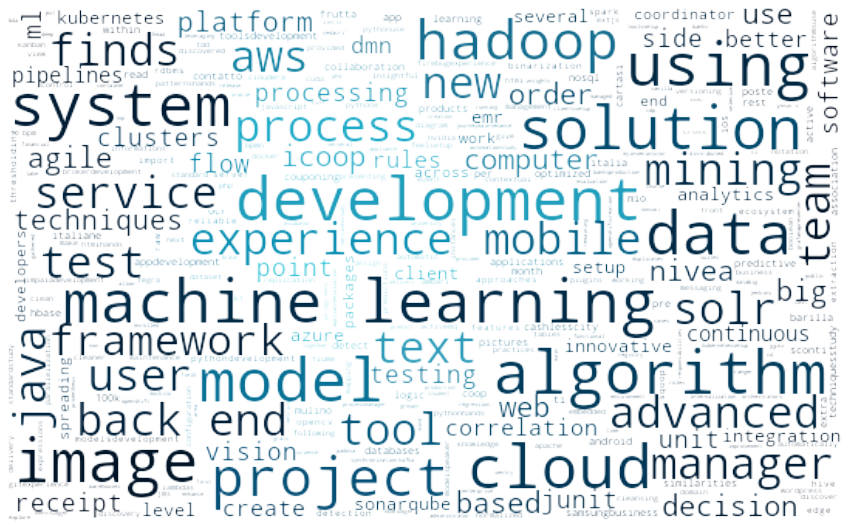

In [62]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_gradient_magnitude

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = os.getcwd()

# load wikipedia text on rainbow
text = long_text.lower()

# load image. This has been modified in gimp to be brighter and have more saturation.
background_color = np.array(Image.open(os.path.join(d, "images/background.jpeg")))
# subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
background_color = background_color[::3, ::3]

# create mask  white is "masked out"
background_mask = background_color.copy()
background_mask[background_mask.sum(axis=2) == 0] = 255

# some finesse: we enforce boundaries between colors so they get less washed out.
# For that we do some edge detection in the image
edges = np.mean([gaussian_gradient_magnitude(background_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
background_mask[edges > .08] = 255

stopwords = set(STOPWORDS)
stopwords.add("different")

# create wordcloud. A bit sluggish, you can subsample more strongly for quicker rendering
# relative_scaling=0 means the frequencies in the data are reflected less
# acurately but it makes a better picture
wc = WordCloud(max_words=2000, mask=background_mask, max_font_size=40, random_state=42, relative_scaling=0, stopwords=stopwords, background_color="rgba(255, 255, 255, 0)", mode="RGBA")

# generate word cloud
wc.generate(text)

# create coloring from image
image_colors = ImageColorGenerator(background_color)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
wc.to_file("images/word_cloud.png")
plt.show()

__________________
## EDUCATION
### October 2017 - Present, Member of the <a href="https://www.dsaiparma.it/" target="_blank">Data Science and AI group in Parma</a>
<img src="dsai.jpeg" width=70 align="right">

#### Parma

* Speaker at public events on Machine Learning and Data Science topics


### September 2012 - March 2015, Master's Degree in Computer Engineering QEQ7
<img src="unibo.png" width=90 align="right">

#### University of Bologna, Bologna

* Computer vision, data mining, use of Hadoop framework, information security, artificial intelligence, computer networks, mobile systems, OpenCV, Java, C/C++, VHDL, IT, Real-Time systems.

**Thesis** *Development of parallel processing approach to compute Zero-mean Normalized Cross- Correlation. CUDA framework has been used to develop fast approach to detect characters in images, using Template Matching approach, based on Zero-mean Normalized Cross-Correlation measure.*

**Final Grade** 110/110 with Honours


### September 2009 - July 2012, Bachelor's Degree in Computer Engineering QEQ6
<img src="unipr.png" width=90 align="right">

#### University of Parma, Parma
* Computer science, mathematics, physic, industrial robotics, web programming, electronics, automatics, computer graphics, software engineering, Java, C/C++, OpenGL

**Thesis** *A Machine Learning project based on arm gesture recognition and humanoid imitation. Arm gestures are acquired by inertial motion sensors and modelled in an OpenGL 3D virtual space. A new method based on Functional Principal Component Analysis is used in MATLAB for both a supervised clustering of training data and gesture recognition. Recognized gestures are imitated by a small humanoid robot*

**Final grade** 107/110

______________
## PERSONAL SKILLS
### LANGUAGES

*Levels: A1/2: Basic user - B1/2: Independent user - C1/2 Proficient user - MT Mother Tongue*

In [36]:
lan = pd.read_sql_query('SELECT * FROM language', conn)
print(lan.to_markdown())

|    | Language   | Listening   | Reading   | Spoken Interaction   | Spoken Production   | writing   |
|---:|:-----------|:------------|:----------|:---------------------|:--------------------|:----------|
|  0 | Italian    | MT          | MT        | MT                   | MT                  | MT        |
|  1 | English    | C2          | C2        | C2                   | C2                  | C2        |
|  2 | German     | A1          | A1        | A1                   | A1                  | A1        |
|  3 | French     | A1          | A1        | A1                   | A1                  | A1        |




### COMMUNICATION SKILLS
I gained good communication skills speaking and interacting with customers and clents. I'm also part of the Data Science and Artificial Intelligence Group in Parma, and I give a speech about Machine Learning topics once every few months, usually in front of dozens of peoples.

### ORGANISATIONAL/MANAGERIAL SKILLS
Excellent social/organisational skills acquired during my experience as Team Leader/Area Manager. 

### JOB-RELATED SKILLS

In [46]:
def show_skills_plot(x_label, output_file_name, skills=None):
    if skills is None:
        raise Exception("you should have at least one skill, shouldn't you?")
    from bokeh.io import show, output_notebook
    from bokeh.plotting import figure
    from bokeh.palettes import Blues9
    from bokeh.transform import factor_cmap
    from bokeh.models import ColumnDataSource
    output_file(output_file_name)

    
    source = ColumnDataSource(skills)
    
    TOOLTIPS = """
        <div style="width:300px">
            <table>
                <tr><td style="color:DodgerBlue;">Name</td><td style="text-align: center;"><b>@description</b></td></tr>
                <tr><td style="color:DodgerBlue;">Type</td><td style="text-align: center;">@subtype</td></tr>
                <tr><td style="color:DodgerBlue;">Details</td><td style="text-align: center;">@tooltip</td></tr>
            </table>
        </div>
    """

    p = figure(plot_width=700, plot_height=400, title="Expertise level",
               x_range=list(skills.description), toolbar_location=None, tooltips=TOOLTIPS)
        
    index_cmap = factor_cmap('subtype', palette=Blues9, factors=sorted(skills.subtype.unique()), end=1) 
    p.vbar(x='description', top='level', width=1, source=source,
           line_color="white", fill_color=index_cmap)

    p.y_range.start = 0
    p.y_range.end = 10
    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.xaxis.axis_label = x_label
    p.xaxis.major_label_orientation = 1.2
    #p.xaxis.major_label_text_color = 'white'
    #p.yaxis.major_label_text_color = 'white'
    #p.xaxis.axis_label_text_color = 'white'
    p.outline_line_color = None
    #p.background_fill_color = "#323A48"
    #p.border_fill_color = "#323A48"
    #p.title.text_color = "white"

    show(p)

job_skills = pd.read_csv('legacy/job_skills.csv', sep=';')
job_skills['subtype'] = job_skills.apply(lambda x : x.type if pd.isna(x.subtype) else x.subtype, axis=1)

**Programming Languages**

In [27]:
show_skills_plot('Programming Languages', 'html/programming_laguages.html', job_skills[job_skills.type == 'Programming Language'])

**Java & DevOps**

In [30]:
show_skills_plot('Java & DevOps', 'html/java_dev_ops.html', job_skills[job_skills.type.isin(['Java','DevOps'])].sort_values(by = ['subtype','level'], ascending=False))

**Containers**

In [47]:
show_skills_plot('Containers', 'html/containers.html', job_skills[job_skills.type.isin(['Containers'])].sort_values(by = ['subtype','level'], ascending=False))

**Big Data**

In [32]:
show_skills_plot('Big Data', 'html/big_data.html', job_skills[job_skills.type.isin(['Big Data'])].sort_values(by = ['subtype','level'], ascending=False))

**Other job-related skills**

In [33]:
show_skills_plot('Skills grouped by type', 'html/others.html',
                 job_skills[job_skills.type.isin([key for key in list(job_skills.type.unique()) if key not in ['Java', 'DevOps', 'Containers', 'Programming Language']])])

### OTHER SKILLS
**Sport**: 
* American Football, 4 years’ experience in the Parma Panthers, interaction with American staff and players. Participation in European Championship with the Italian National American Football team

**Driving License**: B (own car)
______________
## ADDITIONAL INFORMATION
**Publications**

[Arm Gesture Recognition and Humanoid Imitation Using Functional Principal Component Analysis](https://ieeexplore.ieee.org/abstract/document/6696892),<br>
J. Aleotti, A. Cionini, L. Fontanili, S. Caselli,<br>
IEEE/RSJ International Conference on Intelligent Robotics and Systems (IROS),<br>
Tokyo, November 2013

**Challenges**

**[Generali Data Challenge](https://generali.datachallenge.it/competitions/40#final)**: top 10 finalist

**Speaking**

**[BPMNext 2019](https://youtu.be/cBeZX_S4vGo)**: Process Mining and DTO — How to Derive Business Rules and ROI from the Data

**[Cloud, the “New Normal”](https://www.ikn.it/evento/11088/free-webinar-cloud-the-new-normal-per-banche-e-assicurazioni/speaker)**: Casi concreti di trasformazione e innovazione nel settore dei servizi finanziari

**Honours and awards**

Bronze medal of sporting merit given by CONI

**Certifications**

* Process Mining: Data science in Action, Eindhoven University of Technology [Coursera, #R95WTVQ56CQS](https://www.coursera.org/account/accomplishments/verify/R95WTVQ56CQS)
* Machine Learning, Stanford University, [Coursera, #FGYRSK7XD8XG](https://www.coursera.org/account/accomplishments/verify/FGYRSK7XD8XG)
* Using Python for Research, Harvard University, [edX, #f079493d7801420388179e219e2a9d63](https://courses.edx.org/certificates/f079493d7801420388179e219e2a9d63)
* AWS Certfied Solution Architect Associate, [AWS, #XR710Y4DD2F41N9C](https://www.youracclaim.com/badges/61dfd9e1-489e-405a-ad04-ef48305cd618)

**Projects**

* **[myInvenio](https://www.my-invenio.com)**: A Process Mining tool to gather insightful from business processes
* Development of projects of personal interest using latest mobile and web programming languages (Android, HTML, CSS, SQL, JavaScript, Python) and tools (Nutch crawler, SonarQube, Tesseract).
* **[Ti Frutta](https://www.tifrutta.it)**: The very first "cash back" app in Italy that allows the customer to earn by shopping
* **[F Abbigliamento](https://www.fontaniliabbigliamento.it)**: development of the Fontanili Abbigliamento website using Wordpress CRM
* **CV – Eye Detector**: development of an eye detector in C++ based on Normalized Cross Correlation, robust to light variation
* **DSS – Hadoop**: implementation in Apache Hadoop environment of the Distributed Solving Set algorithm for outlier detection in large distributed data sets, using the MapReduce model
* **Parma Panthers Official**:  development of the Android official application of the Parma Panthers, the American Football team 4 times champion of Italy in the main championship
* **PicoPic**: VHDL project of a Peripheral Interface Controller for a stereo vision system on FPGA, with a 8 bit RISC microprocessor PicoBlaze
* **Wikiquote Search Engine**: implementation of a web crawler for Wikiquote based on Apache Nutch and development of a Java search engine based on Apache Solr
* **[pysqoop](https://pypi.org/project/pysqoop/)**: a Python package that lets you sqoop into HDFS data from RDBMS using Apache Sqoop (installable via pip)
* Member & Speaker of the Data Science & AI Group in Parma

______________
## STUDIES
### BOOKS

In [6]:
pd.read_sql_query('SELECT * FROM books order by status desc, author asc, title asc', conn)

,title,author,status
0,Mastering Java Machine Learining,"Kamath, Uday",reading
1,"The Art of Computer Programming, Fundamental Algorithms","Knuth, Donald",reading
2,Test-Driven Development,"Beck, Kent",read
3,Effective Java,"Bloch, Josua",read
4,Bayesian Methods for Hackers: Probabilistic Programming and Bayesian Inference,"Davidson-Pilon, Cameron",read
5,Design Patterns,"Gamma, Helm, Johnson, Vlissides",read
6,97 Things Every Programmer Should Know,"Henney, Kevlin",read
7,Agile Software Development,"Martin, Robert C.",read
8,Clean Code,"Martin, Robert C.",read
9,The Clean Coder,"Martin, Robert C.",read


### COURSES

In [7]:
pd.read_sql_query('SELECT * FROM courses order by status desc, platform desc, held_by asc, title asc', conn)

,title,held_by,platform,status
0,Analytics in Python,Columbia,edX,completed
1,Artificial Intelligence,Columbia,edX,completed
2,Machine Learning,Columbia,edX,completed
3,Robotics,Columbia,edX,completed
4,Using Python for Research,Harvard,edX,completed
5,Python for Data Science,UC San Diego,edX,completed
6,Blockchain for Business,Udemy,Udemy,completed
7,Certified Kubernetes Application Developer (CKAD),Sighup,Sighup,completed
8,Blockchain – Principles and Practices,Pluralsight,Pluralsight,completed
9,Building Your First scikit-learn Solution,Pluralsight,Pluralsight,completed


______________
### GET IN TOUCH
Feel free to contact me at:

<center><a href="mailto:luca.fontanili93@gmail.com"><i class="fa fa-envelope"></i>luca.fontanili93@gmail.com</a></center>

In [1]:
from bokeh.io import output_file, show
from bokeh.layouts import column
from bokeh.plotting import figure

output_file("layout.html")

x = list(range(11))
y0 = x
y1 = [10 - i for i in x]
y2 = [abs(i - 5) for i in x]

# create three plots
s1 = figure(plot_width=250, plot_height=250, background_fill_color="#fafafa")
s1.circle(x, y0, size=12, color="#53777a", alpha=0.8)

s2 = figure(plot_width=250, plot_height=250, background_fill_color="#fafafa")
s2.triangle(x, y1, size=12, color="#c02942", alpha=0.8)

s3 = figure(plot_width=250, plot_height=250, background_fill_color="#fafafa")
s3.square(x, y2, size=12, color="#d95b43", alpha=0.8)

# put the results in a column and show
show(column(s1, s2, s3))

In [37]:
display()

,Language,Listening,Reading,Spoken Interaction,Spoken Production,writing
0,Italian,MT,MT,MT,MT,MT
1,English,C2,C2,C2,C2,C2
2,German,A1,A1,A1,A1,A1
3,French,A1,A1,A1,A1,A1


In [39]:
print(HTML(lan.to_html()).data)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Language</th>
      <th>Listening</th>
      <th>Reading</th>
      <th>Spoken Interaction</th>
      <th>Spoken Production</th>
      <th>writing</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Italian</td>
      <td>MT</td>
      <td>MT</td>
      <td>MT</td>
      <td>MT</td>
      <td>MT</td>
    </tr>
    <tr>
      <th>1</th>
      <td>English</td>
      <td>C2</td>
      <td>C2</td>
      <td>C2</td>
      <td>C2</td>
      <td>C2</td>
    </tr>
    <tr>
      <th>2</th>
      <td>German</td>
      <td>A1</td>
      <td>A1</td>
      <td>A1</td>
      <td>A1</td>
      <td>A1</td>
    </tr>
    <tr>
      <th>3</th>
      <td>French</td>
      <td>A1</td>
      <td>A1</td>
      <td>A1</td>
      <td>A1</td>
      <td>A1</td>
    </tr>
  </tbody>
</table>
